# Выбор локации для скважины

Проект выполнен для нефтедобывающей компании. Предоставлены данные проб нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Необходимо определить локацию для бурения новой скважины.

Шаги для выбора локации:

- в избранном регионе ищут месторождения, для каждого определяют значения признаков;
- строят модель и оценивают объём запасов;
- выбирают месторождения с самым высокими оценками значений; количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- прибыль равна суммарной прибыли отобранных месторождений.

Условия задачи:

•	Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).

•	При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.

•	Бюджет на разработку скважин в регионе — 10 млрд рублей.

•	При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.

•	После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

**Цель исследования** - построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Анализ возможной прибыли и рисков провести, используя технику *Bootstrap.*

**Ход исследования:**

1. Общая информация о данных:

   1.1 загрузка данных 
   
   1.2 предобработка данных (поиск аномалий, пропусков, дубликатов, анализ статистических характеристик данных)
   
2. Обучение и проверка модели каждого региона:

   2.1 подготовка признакоа (обучающая и валидационная выборка в соотношении 75:25);
   
   2.2 обучение модели линейной регрессии и построение прогноза на валидационной выборке;
   
   2.3 рассчет среднего запаса предсказанного сырья (по валидационной выборки) и RMSE модели.
   
3. Подготовка к рассчету прибыли:

   3.1. расчет достаточного объёма сырья для безубыточной разработки новой скважины и его сравнение со средним запасом в каждом регионе. 
   
4. Рассчет прибыли и рисков

   4.1 написание функции для расчёта прибыли по выбранным скважинам и предсказаниям модели 
   
   4.2 рассчет рисков и прибыли для каждого региона:
   
       - для Bootstrap отбираем 1000 выборок, чтобы найти распределение прибыли;
       
       - рассчет средней прибыли, 95%-й доверительный интервал и риск убытков. 
       
5. Общий вывод с рекоммендацией региона для разработки скважи.

## Загрузка и подготовка данных

### Общая информация о данных

In [1]:
# импорт библиотек

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [2]:
# загрузка данных

reg_1 = pd.read_csv('/datasets/geo_data_0.csv')
reg_2 = pd.read_csv('/datasets/geo_data_1.csv')
reg_3 = pd.read_csv('/datasets/geo_data_2.csv')

**Данные геологоразведки первого региона**

In [3]:
reg_1.info()
reg_1.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647


**Данные геологоразведки второго региона**

In [4]:
reg_2.info()
reg_2.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305


**Данные геологоразведки третьего региона**

In [5]:
reg_3.info()
reg_3.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910


### Предобработка данных

In [6]:
# приведем id к нижнему регистру

reg_1['id'] = reg_1['id'].str.lower()
reg_2['id'] = reg_2['id'].str.lower()
reg_3['id'] = reg_3['id'].str.lower()

In [7]:
print('Количество явных дубликатов в регионе 1:', reg_1.duplicated().sum())
print('Количество явных дубликатов в регионе 2:', reg_2.duplicated().sum())
print('Количество явных дубликатов в регионе 3:', reg_3.duplicated().sum())

Количество явных дубликатов в регионе 1: 0
Количество явных дубликатов в регионе 2: 0
Количество явных дубликатов в регионе 3: 0


In [8]:
print('Количество дубликатов по id в регионе 1:', reg_1.duplicated(['id']).sum())
print('Количество дубликатов по id в регионе 2:', reg_2.duplicated(['id']).sum())
print('Количество дубликатов по id в регионе 3:', reg_3.duplicated(['id']).sum())


Количество дубликатов по id в регионе 1: 113
Количество дубликатов по id в регионе 2: 113
Количество дубликатов по id в регионе 3: 99


Во всех регионах по `id` имеются дубликаты. Учитывая, что значения в `f0`, `f1`, `f2`, `product` различны, не предоставлена вся информация, характеризующая `f0`, `f1`, `f2`,  а также объем дубликатов не значителен, то оставим данные без изменения. Поскольку столбец `id` в задаче не несет для модели значимой информации, удалим его.

In [9]:
# удалим столбец id из датасетов

reg_1 = reg_1.drop(['id'], axis = 1)
reg_2 = reg_2.drop(['id'], axis = 1)
reg_3 = reg_3.drop(['id'], axis = 1)

**Проанализируем данные на наличие выбросов**

In [10]:
# функция для построиения диаграммы размаха

def range_diagram(region, name):
    fig, axes = plt.subplots(1, 3, figsize=(12, 3))
    plt.suptitle(name)

    region.boxplot(['f0', 'f1'], ax=axes[0])
    region.boxplot(['f2'], ax=axes[1])
    region.boxplot(['product'], ax=axes[2]);

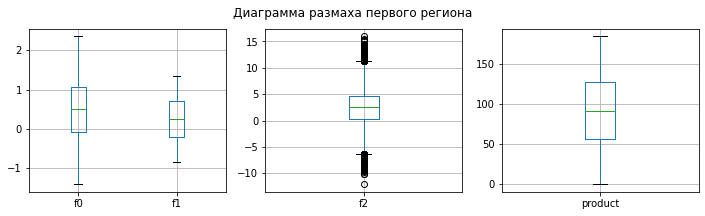

In [11]:
range_diagram(reg_1, 'Диаграмма размаха первого региона')

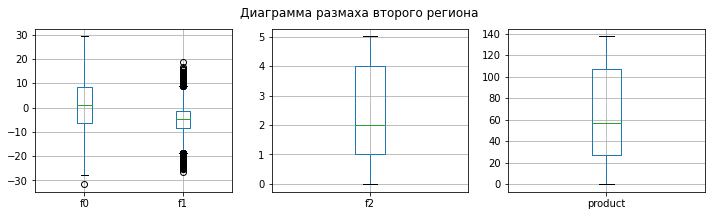

In [12]:
range_diagram(reg_2, 'Диаграмма размаха второго региона')

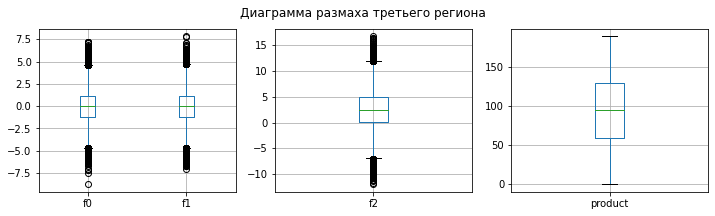

In [13]:
range_diagram(reg_3, 'Диаграмма размаха третьего региона')

По диаграммам размаха видно, что в признаках `f0`, `f1` и `f2` имеются "слабые" выбросы (значения, которые в 1.5 р превышают межквартильный размах). Поскольку информации о данных, характеризующих признаки недостаточно, то судить насколько данные выбросы аномальны сложно. Оставим без изменений и не будем удалять выбросы. Также можно заметить, что признаки отличаются по регионам, особенно выделяется второй регион.

**Проанализируем распределение данных по регионам**

In [14]:
# функция построения гистограм

def distribution (region, name, bin):
    fig, axes = plt.subplots(1, 4, figsize=(18, 4))
    plt.suptitle(name)

    region['f0'].hist(bins=bin, ax=axes[0])
    axes[0].set_title('f0')
    region['f1'].hist(bins=bin, ax=axes[1])
    axes[1].set_title('f1')
    region['f2'].hist(bins=bin, ax=axes[2])
    axes[2].set_title('f2')
    region['product'].hist(bins=bin, ax=axes[3])
    axes[3].set_title('product');

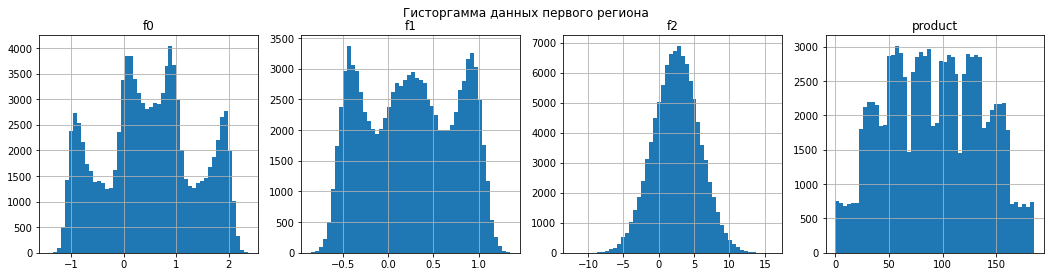

In [15]:
distribution (reg_1, 'Гисторгамма данных первого региона', 50)

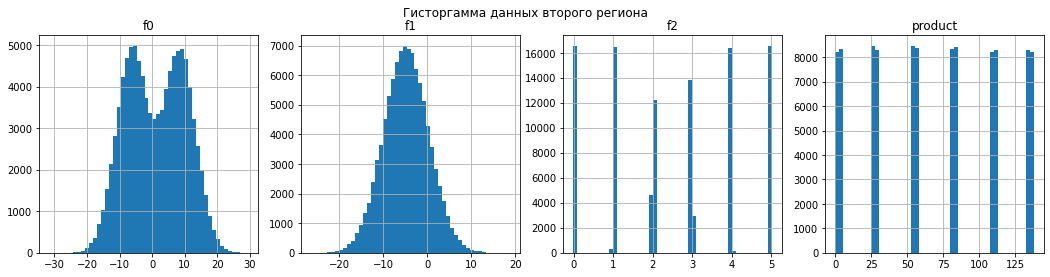

In [16]:
distribution (reg_2, 'Гисторгамма данных второго региона', 50)

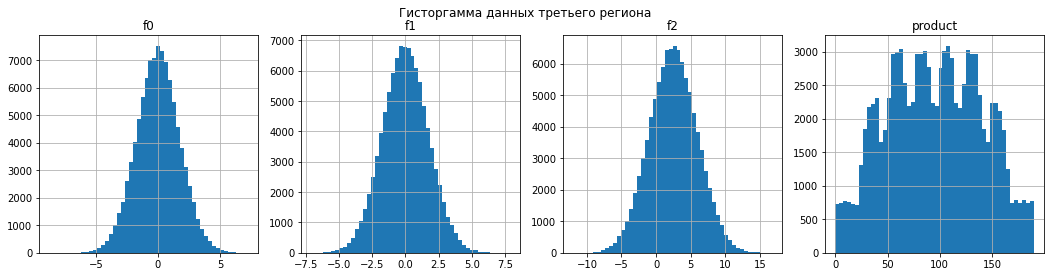

In [17]:
distribution (reg_3, 'Гисторгамма данных третьего региона', 50)

По гистограммам можно сказать, что распределение данных как по регионам, так и по признакам различно. В данном случае можно выделить второй регион. 

**Исследуем взаимосвязь в данных на основе корреляции Пирсона**

In [18]:
# корреляционный анализ первого региона

reg_1.corr()

,f0,f1,f2,product
f0,1.000000,-0.440723,-0.003153,0.143536
f1,-0.440723,1.000000,0.001724,-0.192356
f2,-0.003153,0.001724,1.000000,0.483663
product,0.143536,-0.192356,0.483663,1.000000


In [19]:
# корреляционный анализ второго региона

reg_2.corr()

,f0,f1,f2,product
f0,1.000000,0.182287,-0.001777,-0.030491
f1,0.182287,1.000000,-0.002595,-0.010155
f2,-0.001777,-0.002595,1.000000,0.999397
product,-0.030491,-0.010155,0.999397,1.000000


In [20]:
# корреляционный анализ третьего региона

reg_3.corr()

,f0,f1,f2,product
f0,1.000000,0.000528,-0.000448,-0.001987
f1,0.000528,1.000000,0.000779,-0.001012
f2,-0.000448,0.000779,1.000000,0.445871
product,-0.001987,-0.001012,0.445871,1.000000


В данных трех регионов присутствует линейная зависимость между признаком `f2` и целевым признаком `product`, особо сильно взаимосвязь наблюдается во втором регионе. Также для признаков `f1` и `f0` первого региона наблюдается отрицательная линейная взаимосвязь. 

**Промежуточный вывод**. Данные трех регионов имеют одинаковый объем: 5 столбцов и 100000 строк. Типы данных корректны, пропуски отсутствуют. Имеются дубликаты по `id` и выбросы в признаках. Распределение признаков по регионам различно, между признаком `f2` и целевым признаком `product` наблюдается линейная взаимосвязь.

## Обучение и проверка модели каждого региона

### Подготовка признаков

**Выделим признаки и целевой признак**

In [21]:
# первый регион

target_reg_1 = reg_1['product']
features_reg_1 = reg_1.drop('product', axis=1)

In [22]:
# второй регион

target_reg_2 = reg_2['product']
features_reg_2 = reg_2.drop('product', axis=1)

In [23]:
# третий регион

target_reg_3 = reg_3['product']
features_reg_3 = reg_3.drop('product', axis=1)

**Разобъем данные на обучающую и валидационную выборки**

In [24]:
# первый регион

feat_train_1, feat_valid_1, target_train_1, target_valid_1 = train_test_split(features_reg_1,
                                                                              target_reg_1, 
                                                                              test_size=0.25, 
                                                                              random_state=12345)
print('Объем обучающей выборки первого региона:', feat_train_1.shape)
print('Объем валидационной выборки первого региона:', feat_valid_1.shape)

Объем обучающей выборки первого региона: (75000, 3)
Объем валидационной выборки первого региона: (25000, 3)


In [25]:
# второй регион

feat_train_2, feat_valid_2, target_train_2, target_valid_2 = train_test_split(features_reg_2,
                                                                              target_reg_2, 
                                                                              test_size=0.25, 
                                                                              random_state=12345)
print('Объем обучающей выборки второго региона:', feat_train_2.shape)
print('Объем валидационной выборки второго региона:', feat_valid_2.shape)

Объем обучающей выборки второго региона: (75000, 3)
Объем валидационной выборки второго региона: (25000, 3)


In [26]:
# третий регион

feat_train_3, feat_valid_3, target_train_3, target_valid_3 = train_test_split(features_reg_3,
                                                                              target_reg_3, 
                                                                              test_size=0.25, 
                                                                              random_state=12345)
print('Объем обучающей выборки третьего региона:', feat_train_3.shape)
print('Объем валидационной выборки второго региона:', feat_valid_3.shape)

Объем обучающей выборки третьего региона: (75000, 3)
Объем валидационной выборки второго региона: (25000, 3)


**Выполним масштабирование признаков**

Данные геологоразведки имеют разный размах значений, поэтому выполним масштабирование признаков 

In [27]:
# скрываем предупреждение Python

pd.options.mode.chained_assignment = None

# масштабируем признаки выборок

numeric = ['f0', 'f1', 'f2']

In [28]:
# первый регион

scaler_1 = StandardScaler()
scaler_1.fit(feat_train_1[numeric])

feat_train_1[numeric] = scaler_1.transform(feat_train_1[numeric])
feat_valid_1[numeric] = scaler_1.transform(feat_valid_1[numeric])

In [29]:
# второй регион

scaler_2 = StandardScaler()
scaler_2.fit(feat_train_2[numeric])

feat_train_2[numeric] = scaler_2.transform(feat_train_2[numeric])
feat_valid_2[numeric] = scaler_2.transform(feat_valid_2[numeric])

In [30]:
# третий регион

scaler_3 = StandardScaler()
scaler_3.fit(feat_train_3[numeric])

feat_train_3[numeric] = scaler_3.transform(feat_train_3[numeric])
feat_valid_3[numeric] = scaler_3.transform(feat_valid_3[numeric])

### Обучение модели и прогнозирование объема запасов нефти

**Первый регион**

In [31]:
# обучение модели на тренировочной выборке и предсказание на валидационной

model_1 = LinearRegression().fit(feat_train_1, target_train_1)
predict_valid_1 = model_1.predict(feat_valid_1)

print('')
print('Предсказания запасов нефти: predict_valid_1')
print('Реальные запасы нефти: target_valid_1')


Предсказания запасов нефти: predict_valid_1
Реальные запасы нефти: target_valid_1


In [32]:
# рассчет метрики RMSE

rmse_1 = mean_squared_error(target_valid_1, predict_valid_1)**0.5
print('RMSE модели первого региона:', rmse_1)

RMSE модели первого региона: 37.5794217150813


**Второй регион**

In [33]:
# обучение модели на тренировочной выборке и предсказание на валидационной

model_2 = LinearRegression().fit(feat_train_2, target_train_2)
predict_valid_2 = model_2.predict(feat_valid_2)

print('')
print('Предсказания запасов нефти: predict_valid_2')
print('Реальные запасы нефти: target_valid_2')


Предсказания запасов нефти: predict_valid_2
Реальные запасы нефти: target_valid_2


In [34]:
# рассчет метрики RMSE

rmse_2 = mean_squared_error(target_valid_2, predict_valid_2)**0.5
print('RMSE модели второго региона:', rmse_2)

RMSE модели второго региона: 0.893099286775617


**Третий регион**

In [35]:
# обучение модели на тренировочной выборке и предсказание на валидационной

model_3 = LinearRegression().fit(feat_train_3, target_train_3)
predict_valid_3 = model_3.predict(feat_valid_3)

print('')
print('Предсказания запасов нефти: predict_valid_3')
print('Реальные запасы нефти: target_valid_3')


Предсказания запасов нефти: predict_valid_3
Реальные запасы нефти: target_valid_3


In [36]:
# рассчет метрики RMSE

rmse_3 = mean_squared_error(target_valid_3, predict_valid_3)**0.5
print('RMSE модели третьего региона:', rmse_3)

RMSE модели третьего региона: 40.02970873393434


**Сводная таблица по запасам нефти**

In [37]:
total_table = pd.DataFrame(index=['Средний запас предсказанного сырья', 'RMSE модели'], 
                           columns=['Первый регион', 'Второй регион', 'Третий регион'])
total_table['Первый регион'] = predict_valid_1.mean(), rmse_1
total_table['Второй регион'] = predict_valid_2.mean(), rmse_2
total_table['Третий регион'] = predict_valid_3.mean(), rmse_3
total_table

,Первый регион,Второй регион,Третий регион
Средний запас предсказанного сырья,92.592568,68.728547,94.965046
RMSE модели,37.579422,0.893099,40.029709


**Промежуточный вывод.** Поскольку данные и целевой признак количественные, то для решения поставленной задачи выбрана модель линейная регрессия. На основе обученной модели получено прогнозное значение среднего запаса сырья в каждом регионе. Для оценки качества модели рассчитана метрика среднеквадратическая ошибка (RMSE):

- средний запас нефти для первого региона: 92.59 и RMSE 37.6;
- средний запас нефти для второго региона: 68.73 и RMSE 0.89;
- средний запас нефти для третьего региона: 94.97 и RMSE 40.03

Минимальная RMSE получена для данных второго региона, это очевидно, поскольку между признаком `f2` и целевым признаком `product` в п. 1.2 выявлена сильная линейная зависимость. При этом для второго региона спрогнозирован наименьший объем сырья.

## Подготовка к расчёту прибыли

**Сохраним ключевые значения из условия задачи в отдельных переменных**

In [38]:
budget = 10000000000         # бюджет на разработку скважин
points_per_budget = 200      # количество точек для разработки при заданном бюджете
income_per_barrel = 450000   # доход с одной тысячи барреля сырья
well_num = 500               # количество рабочих скважин

In [39]:
# объем сырья для безубыточной разработки 200 скважин

profit_product = budget / income_per_barrel

# объем сырья для безубыточной разработки 1 скважины

well_profit = profit_product / points_per_budget
print('Количество сырья для безубыточной разработки (тыс.баррелей):', well_profit)

Количество сырья для безубыточной разработки (тыс.баррелей): 111.11111111111111


**Промежуточный вывод.** Анализируя средние предсказанные запасы сырья можно сказать, что максимальные запасы показывает третий регион - 94,96 тыс.баррелей, при этом данного объема недостаточно на 14,5% для безубыточной разработки.

## Расчёт прибыли и рисков 

### Функция для расчёта прибыли по выбранным скважинам и предсказаниям модели

In [40]:
def revenue(target, predict, points_per_budget):
    
    # приводим к единообразию данные
    # сортируем прогнозы по убыванию, чтобы выбрать 200 скважин с наибольшим объемом предсказания (predict_sorted)
    # отбираем реальный объем лучших по прогнозам скважин (selected_well)
    
    target = target.reset_index(drop=True)
    predict = pd.Series(predict)
    
    predict_sorted = predict.sort_values(ascending=False)
    selected_well = target[predict_sorted.index][:points_per_budget]
    income = (income_per_barrel * selected_well.sum()) - budget
    
    return income 

In [41]:
# прибыль от 200 скважин первого региона

income = revenue(target_valid_1, predict_valid_1, points_per_budget)
print("Прибыль от объема сырья первого региона:", income)

Прибыль от объема сырья первого региона: 3320826043.1398506


In [42]:
# прибыль от 200 скважин второго региона

income = revenue(target_valid_2, predict_valid_2, points_per_budget)
print("Прибыль от объема сырья второго региона:", income)

Прибыль от объема сырья второго региона: 2415086696.681511


In [43]:
# прибыль от 200 скважин третьего региона

income = revenue(target_valid_3, predict_valid_3, points_per_budget)
print("Прибыль от объема сырья третьего региона:", income)

Прибыль от объема сырья третьего региона: 2710349963.5998325


### Посчитайте риски и прибыль для каждого региона

**Рассчет рисков и прибыли**

In [44]:
# values - массив со значениями прибыли (распределение прибыли), длина массива 1000
# сэмплируем прогнозные значения (а не target, так как проблемы и ошибки с индексами) по 500 скважин
# рассчитываем income с помощью функции revenue
# count - счетчик для убытков

def income_loss(predict, target):
    
    values = [] 
    count = 0
    state = np.random.RandomState(12345)

    for i in range(1000):
        predict_subsample = pd.Series(predict).sample(n=well_num, replace=True, random_state=state) 
        values.append(revenue(target, predict_subsample, points_per_budget))

    values = pd.Series(values)
    
    mean = values.mean()                # средняя прибыль по лучшим 200 скважинам
    lower_95 = values.quantile(0.025)   # верхняя граница 95% квантиля
    upper_95 = values.quantile(0.975)   # нижняя граница 95% квантиля
    
# рассчет убытков
    
    for i in range(len(values)):
        if values[i] < 0:
            count += 1
            loss = (count*100)/1000
    
    return mean, lower_95, upper_95, loss

**Первый регион**

In [45]:
mean_1, lower_95, upper_95, loss_1 = income_loss(predict_valid_1, target_valid_1)
print('Средняя прогнозируемая прибыль:', mean_1)
print('95% доверительный интервал: прибыль может варьироваться в диапазоне от', lower_95, 'до', upper_95)
print('Риск убытков:', loss_1,'%')

Средняя прогнозируемая прибыль: 396164984.8023711
95% доверительный интервал: прибыль может варьироваться в диапазоне от -111215545.89049526 до 909766941.5534226
Риск убытков: 6.9 %


**Второй регион**

In [46]:
mean_2, lower_95, upper_95, loss_2 = income_loss(predict_valid_2, target_valid_2)
print('Средняя прогнозируемая прибыль:', mean_2)
print('95% доверительный интервал: прибыль может варьироваться в диапазоне от', lower_95, 'до', upper_95)
print('Риск убытков:', loss_2,'%')

Средняя прогнозируемая прибыль: 456045105.7866608
95% доверительный интервал: прибыль может варьироваться в диапазоне от 33820509.39898363 до 852289453.866036
Риск убытков: 1.5 %


**Третий регион**

In [47]:
mean_3, lower_95, upper_95, loss_3 = income_loss(predict_valid_3, target_valid_3)
print('Средняя прогнозируемая прибыль:', mean_3)
print('95% доверительный интервал: прибыль может варьироваться в диапазоне от', lower_95, 'до', upper_95)
print('Риск убытков:', loss_3,'%')

Средняя прогнозируемая прибыль: 404403866.5683568
95% доверительный интервал: прибыль может варьироваться в диапазоне от -163350413.39560106 до 950359574.9237995
Риск убытков: 7.6 %


In [48]:
final_table = pd.DataFrame(index=['Средняя прогнозируемая прибыль', 'Риск убытков'], 
                           columns=['Первый регион', 'Второй регион', 'Третий регион'])
final_table['Первый регион'] = mean_1, 6.9
final_table['Второй регион'] = mean_2, 1.5
final_table['Третий регион'] = mean_3, 7.6
final_table

,Первый регион,Второй регион,Третий регион
Средняя прогнозируемая прибыль,3.961650e+08,4.560451e+08,4.044039e+08
Риск убытков,6.900000e+00,1.500000e+00,7.600000e+00


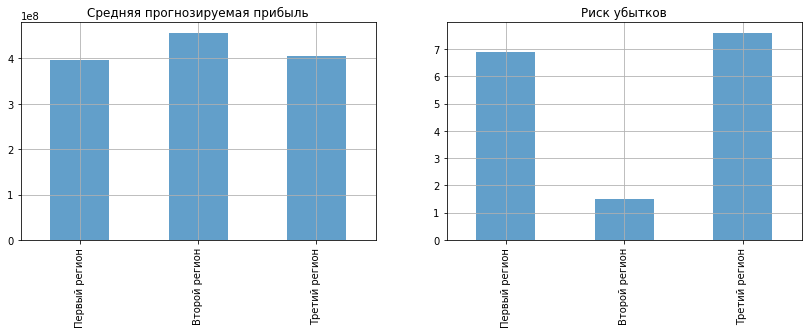

In [49]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

final_table.iloc[0,:].plot(kind="bar", grid=True, alpha=0.7, subplots=True, ax=axes[0])
final_table.iloc[1,:].plot(kind="bar", grid=True, alpha=0.7, subplots=True, ax=axes[1]);

**Промежуточный вывод.** Для рассчета рисков и прибыли в каждом регионе применена техника bootstrap. Анализ финальной таблицы показывает, что менее рисковый регион - второй (с риском убытков 1.5%). Также данный регион показыват наибольшую среднюю прогнозируемую прибыль. Для первого и третьего региона риск убытков составляет 6,9 и 7,6%, соответственно.

## Общий вывод

Проект направлен на построение модели, позволяющей определить перспективный регион для добычи нефти. В качестве исходной информации предоставлены данные геологоразведки трех регионов. Необходимо определить регион, для которого риск убытков составит менее 2.5%.

1. На **этапе предобработки данных:** 
- выявлены дубликаты в столбце с наименованием скважин, а также "слабые" выбросы в признаках точек `f0`, `f1`, `f2`. Поскольку развернутой информации о данных не предоставлено, то никакие действия с ними не выполнялись.
- анализ статистических характеристик данных (диаграмма размаха, гистограмма и коэффициенты корреляции по Пирсону) показал, что среди регионов особо выделяется второй.

2. На **этапе обучения и проверки модели** выполнено разбиение выборки на обучающую и валидационную, а также масштабирование признаков. Поскольку решается задача регрессии и целевой признак количественный, в качестве модели рассмотрена линейная регрессия. На ее основе получен прогноз запасов сырья в каждом регионе, для оценки качества модели выбрана метрика RMSE:

- средний запас нефти для первого региона: 92.59 и RMSE 37.6;
- средний запас нефти для второго региона: 68.73 и RMSE 0.89;
- средний запас нефти для третьего региона: 94.97 и RMSE 40.03

По прогнозу запасов сырья лидирует третий регион, но при этом имеет и наибольшую ошибку RMSE. Наименьший объем сырья по прогнозу показал второй регион, но также для модели данного региона получена наименьшая RMSE.

3. На **этапе рассчета прибыли и рисков** для каждого региона применена техника bootstrap и получены средняя прогнозируемая прибыль и риск убытков. Учитывая условия задачи - ограничение по риску не более 2,5%, более перспективный регион для безубыточной разработки - **второй регион**. Он показал риск в 1,5% и среднюю прогнозируемую прибыль в размере 456045105.78 руб. 